In [1]:
import sys

#if branch is stable, will install via pypi, else will install from source
branch = "stable"
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB and branch == "stable":
    !pip install --quiet scvi-tools[tutorials]
elif IN_COLAB and branch != "stable":
    !pip install --quiet --upgrade jsonschema
    !pip install --quiet git+https://github.com/yoseflab/scvi-tools@$branch#egg=scvi-tools[tutorials]

     |████████████████████████████████| 204kB 8.3MB/s 
     |████████████████████████████████| 81kB 8.5MB/s 
     |████████████████████████████████| 215kB 28.5MB/s 
     |████████████████████████████████| 245kB 35.8MB/s 
     |████████████████████████████████| 634kB 41.0MB/s 
     |████████████████████████████████| 133kB 50.7MB/s 
     |████████████████████████████████| 819kB 54.3MB/s 
     |████████████████████████████████| 1.4MB 45.2MB/s 
     |████████████████████████████████| 3.2MB 53.0MB/s 
     |████████████████████████████████| 51kB 8.5MB/s 
     |████████████████████████████████| 11.3MB 47.6MB/s 
     |████████████████████████████████| 8.8MB 19.1MB/s 
     |████████████████████████████████| 51kB 8.9MB/s 
     |████████████████████████████████| 829kB 48.3MB/s 
     |████████████████████████████████| 645kB 42.7MB/s 
     |████████████████████████████████| 122kB 56.7MB/s 
     |████████████████████████████████| 10.6MB 164kB/s 
     |████████████████████████████████| 235kB 53.6MB/s

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as p9

import scanpy as sc
import scvi

sc.set_figure_params(figsize=(4, 4))

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


Here we focus on two CITE-seq datasets of peripheral blood mononuclear cells from 10x Genomics and used in the totalVI manuscript. We have already filtered these datasets for doublets and low-quality cells and genes.

The quality of totalVI's protein imputation is somewhat reliant on how well the datasets mix in the latent space. In other words, it's assumed here the datasets largely share the same cell subpopulations.

In [3]:
adata = scvi.data.pbmcs_10x_cite_seq(run_setup_anndata=False)

# batch 0 corresponds to dataset_10k, batch 1 corresponds to dataset_5k
batch = adata.obs.batch.values.ravel()
adata.obs.batch

INFO     File data/pbmc_10k_protein_v3.h5ad already downloaded                               
INFO     File data/pbmc_5k_protein_v3.h5ad already downloaded                                


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


index
AAACCCAAGATTGTGA-1    PBMC10k
AAACCCACATCGGTTA-1    PBMC10k
AAACCCAGTACCGCGT-1    PBMC10k
AAACCCAGTATCGAAA-1    PBMC10k
AAACCCAGTCGTCATA-1    PBMC10k
                       ...   
TTTGGTTGTACGAGTG-1     PBMC5k
TTTGTTGAGTTAACAG-1     PBMC5k
TTTGTTGCAGCACAAG-1     PBMC5k
TTTGTTGCAGTCTTCC-1     PBMC5k
TTTGTTGCATTGCCGG-1     PBMC5k
Name: batch, Length: 10849, dtype: object

In [4]:
# hold out the proteins of the 5k dataset by replacing all the values w/ 0s. We 
# store the original values to validate after training
held_out_proteins = adata.obsm['protein_expression'][batch=='PBMC5k'].copy()
adata.obsm['protein_expression'].loc[batch=='PBMC5k'] = np.zeros_like(adata.obsm['protein_expression'][batch=='PBMC5k'])

In [5]:
sc.pp.highly_variable_genes(
    adata,
    batch_key='batch',
    flavor='seurat_v3',
    n_top_genes=4000,
    subset=True
)

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Important

scvi-tools will automatically detect proteins as missing in a certain batch if the protein has 0 counts for each cell in the batch. In other words, to indicate a protein is missing in a certain batch, please set it to 0 for each cell.

In [6]:
scvi.data.setup_anndata(adata, batch_key='batch', protein_expression_obsm_key='protein_expression')

INFO     Using batches from adata.obs["batch"]                                               
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Using protein expression from adata.obsm['protein_expression']                      
INFO     Using protein names from columns of adata.obsm['protein_expression']                
INFO     Found batches with missing protein expression                                       
INFO     Successfully registered anndata object containing 10849 cells, 4000 vars, 2 batches,
         1 labels, and 14 proteins. Also registered 0 extra categorical covariates and 0     
         extra continuous covariates.                                                        
INFO     Please do not further modify adata until model is t

In [7]:
# Prepare and run the model
model = scvi.model.TOTALVI(
    adata,
    latent_distribution='normal',
    n_layers_decoder=2
)

In [8]:
model.train()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 351/400:  88%|████████▊ | 351/400 [07:03<00:59,  1.21s/it, loss=591, v_num=1]


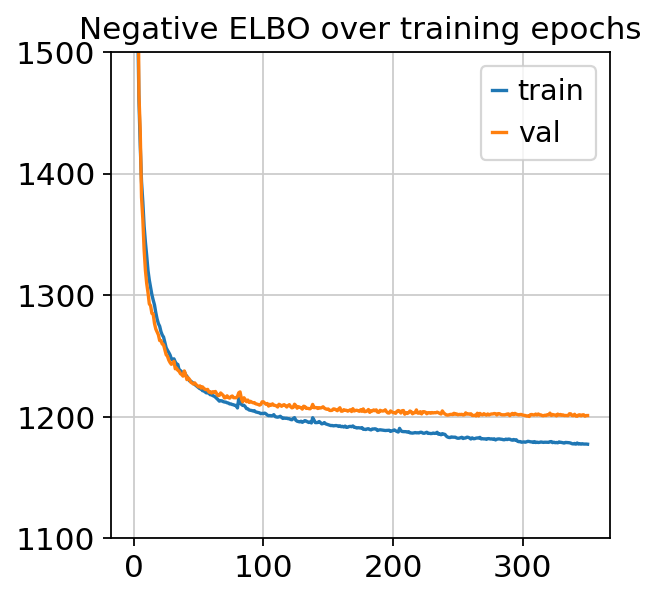

In [9]:
plt.plot(model.history["elbo_train"], label="train")
plt.plot(model.history["elbo_validation"], label="val")
plt.title("Negative ELBO over training epochs")
plt.ylim(1100, 1500)
plt.legend()

In [11]:
adata.obsm['X_totalVI'] = model.get_latent_representation()
adata.obsm['protein_fg_prob'] = model.get_protein_foreground_probability(transform_batch='PBMC10k')

rna, protein = model.get_normalized_expression(transform_batch='PBMC10k', n_samples=25, return_mean=True)

<div class="alert alert-info">

Note

`transform_batch` is a power parameter. Setting this allows one to predict the expression of cells as if they came from the inputted batch. In this case, we've observed protein expression in batch "PBMC10k" (batch categories from original adata object), but we have no protein expression in batch "PBMC5k". We'd like to take the cells of batch "PBMC5k" and make a counterfactual prediction: "What would the expression look like if my batch "PBMC5k" cells came from batch "PBMC10k"?"

</div>

In [12]:
protein.iloc[:5, :5]

,CD3_TotalSeqB,CD4_TotalSeqB,CD8a_TotalSeqB,CD14_TotalSeqB,CD15_TotalSeqB
index,,,,,
AAACCCAAGATTGTGA-1,11.724975,228.810059,1.798293,915.180176,102.371574
AAACCCACATCGGTTA-1,32.118484,209.722122,4.386090,766.817993,104.949043
AAACCCAGTACCGCGT-1,12.012997,399.093323,4.920446,1300.881104,114.296387
AAACCCAGTATCGAAA-1,1.623978,1.158199,45.501251,0.125229,179.936874
AAACCCAGTCGTCATA-1,0.349733,0.015225,41.689796,0.014140,93.235359


<div class="alert alert-info">

Note

The following is for illustrative purposes. In the code blocks above, we have the denoised protein values for each cell. These values have the expected protein background component removed. However, to compare to the held out protein values, we must include both protein foreground and background. We recommend using the values above for downstream tasks.

</div>

In [13]:
_, protein_means = model.get_normalized_expression(
    n_samples=25,
    transform_batch='PBMC10k',
    include_protein_background=True,
    sample_protein_mixing=False,
    return_mean=True,
)

In [14]:
sc.pp.neighbors(adata, use_rep='X_totalVI')
sc.tl.umap(adata, min_dist=0.4)
sc.tl.leiden(adata, key_added='leiden_totalVI')

/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:1229: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
... storing 'batch' as categorical


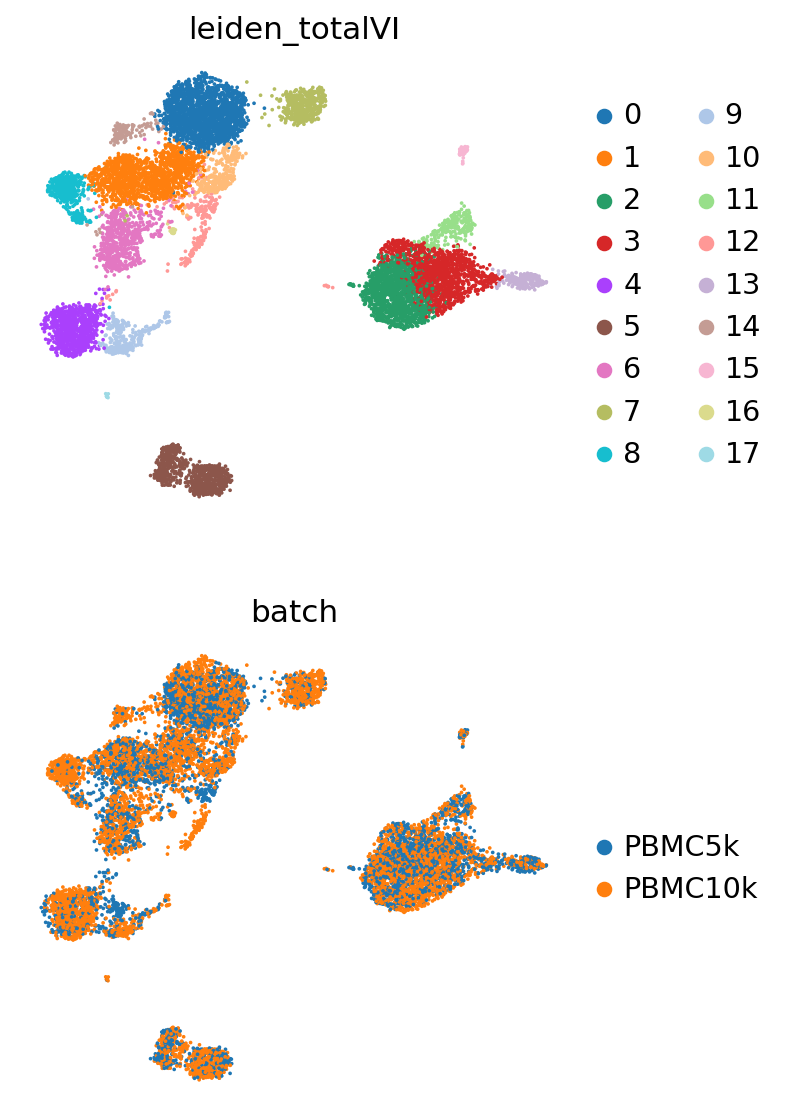

In [16]:
perm_inds = np.random.permutation(len(adata))
sc.pl.umap(
    adata[perm_inds],
    color=['leiden_totalVI', 'batch'],
    ncols=1,
    frameon=False,
)

In [23]:
batch = adata.obs.batch.values.ravel()
combined_protein = np.concatenate([adata.obsm['protein_expression'].values[batch=='PBMC10k'], held_out_proteins], axis=0)

# cleaner protein names
parsed_protein_names = [p.split('_')[0] for p in adata.obsm['protein_expression'].columns]
for i, p in enumerate(parsed_protein_names):
  adata.obs['{} imputed'.format(p)] = protein_means.iloc[:, i]
  adata.obs['{} observed'.format(p)] = combined_protein[:, i]

parsed_protein_names

['CD3',
 'CD4',
 'CD8a',
 'CD14',
 'CD15',
 'CD16',
 'CD56',
 'CD19',
 'CD25',
 'CD45RA',
 'CD45RO',
 'PD-1',
 'TIGIT',
 'CD127']

In [20]:
viz_keys = []
for p in parsed_protein_names:
  viz_keys.append(p + ' imputed')
  viz_keys.append(p + ' observed')

sc.pl.umap(
    adata[adata.obs.batch == 'PBMC5k'],
    color = viz_keys,
    ncols=2,
    vmax='p99',
    frameon=False,
    add_outline=True,
    wspace=0.1
)

Output hidden; open in https://colab.research.google.com to view.

## Imputed vs denoised correlations

In [22]:
from scipy.stats import pearsonr
imputed_pros = protein_means[batch == "PBMC5k"]
held_vs_denoised = pd.DataFrame()
held_vs_denoised["Observed (log)"] = np.log1p(held_out_proteins.values.ravel())
held_vs_denoised["Imputed (log)"] = np.log1p(imputed_pros.to_numpy().ravel())
protein_names_corrs = []

for i, p in enumerate(parsed_protein_names):
    protein_names_corrs.append(parsed_protein_names[i] + ": Corr=" + str(np.round(pearsonr(held_out_proteins.values[:, i], imputed_pros.iloc[:, i])[0], 3)))

held_vs_denoised["Protein"] = protein_names_corrs * len(held_out_proteins)
held_vs_denoised.head()

,Observed (log),Imputed (log),Protein
0,3.258097,3.575961,CD3: Corr=0.786
1,5.105945,6.015245,CD4: Corr=0.879
2,2.833213,3.454413,CD8a: Corr=0.833
3,6.546785,7.212295,CD14: Corr=0.912
4,2.995732,4.842855,CD15: Corr=0.096


We notice that CD15 has a really low correlation (imputation accuracy). Recall that imputation involves a counterfactual query -- "what would the protein expression have been for these cells if they came from the PBMC10k dataset?" Thus, any technical issues with proteins in CD15 in PBMC10k will be reflected in the imputed values. It's the case here that CD15 was not captured as well in the PBMC10k dataset compared to the PBMC5k dataset.

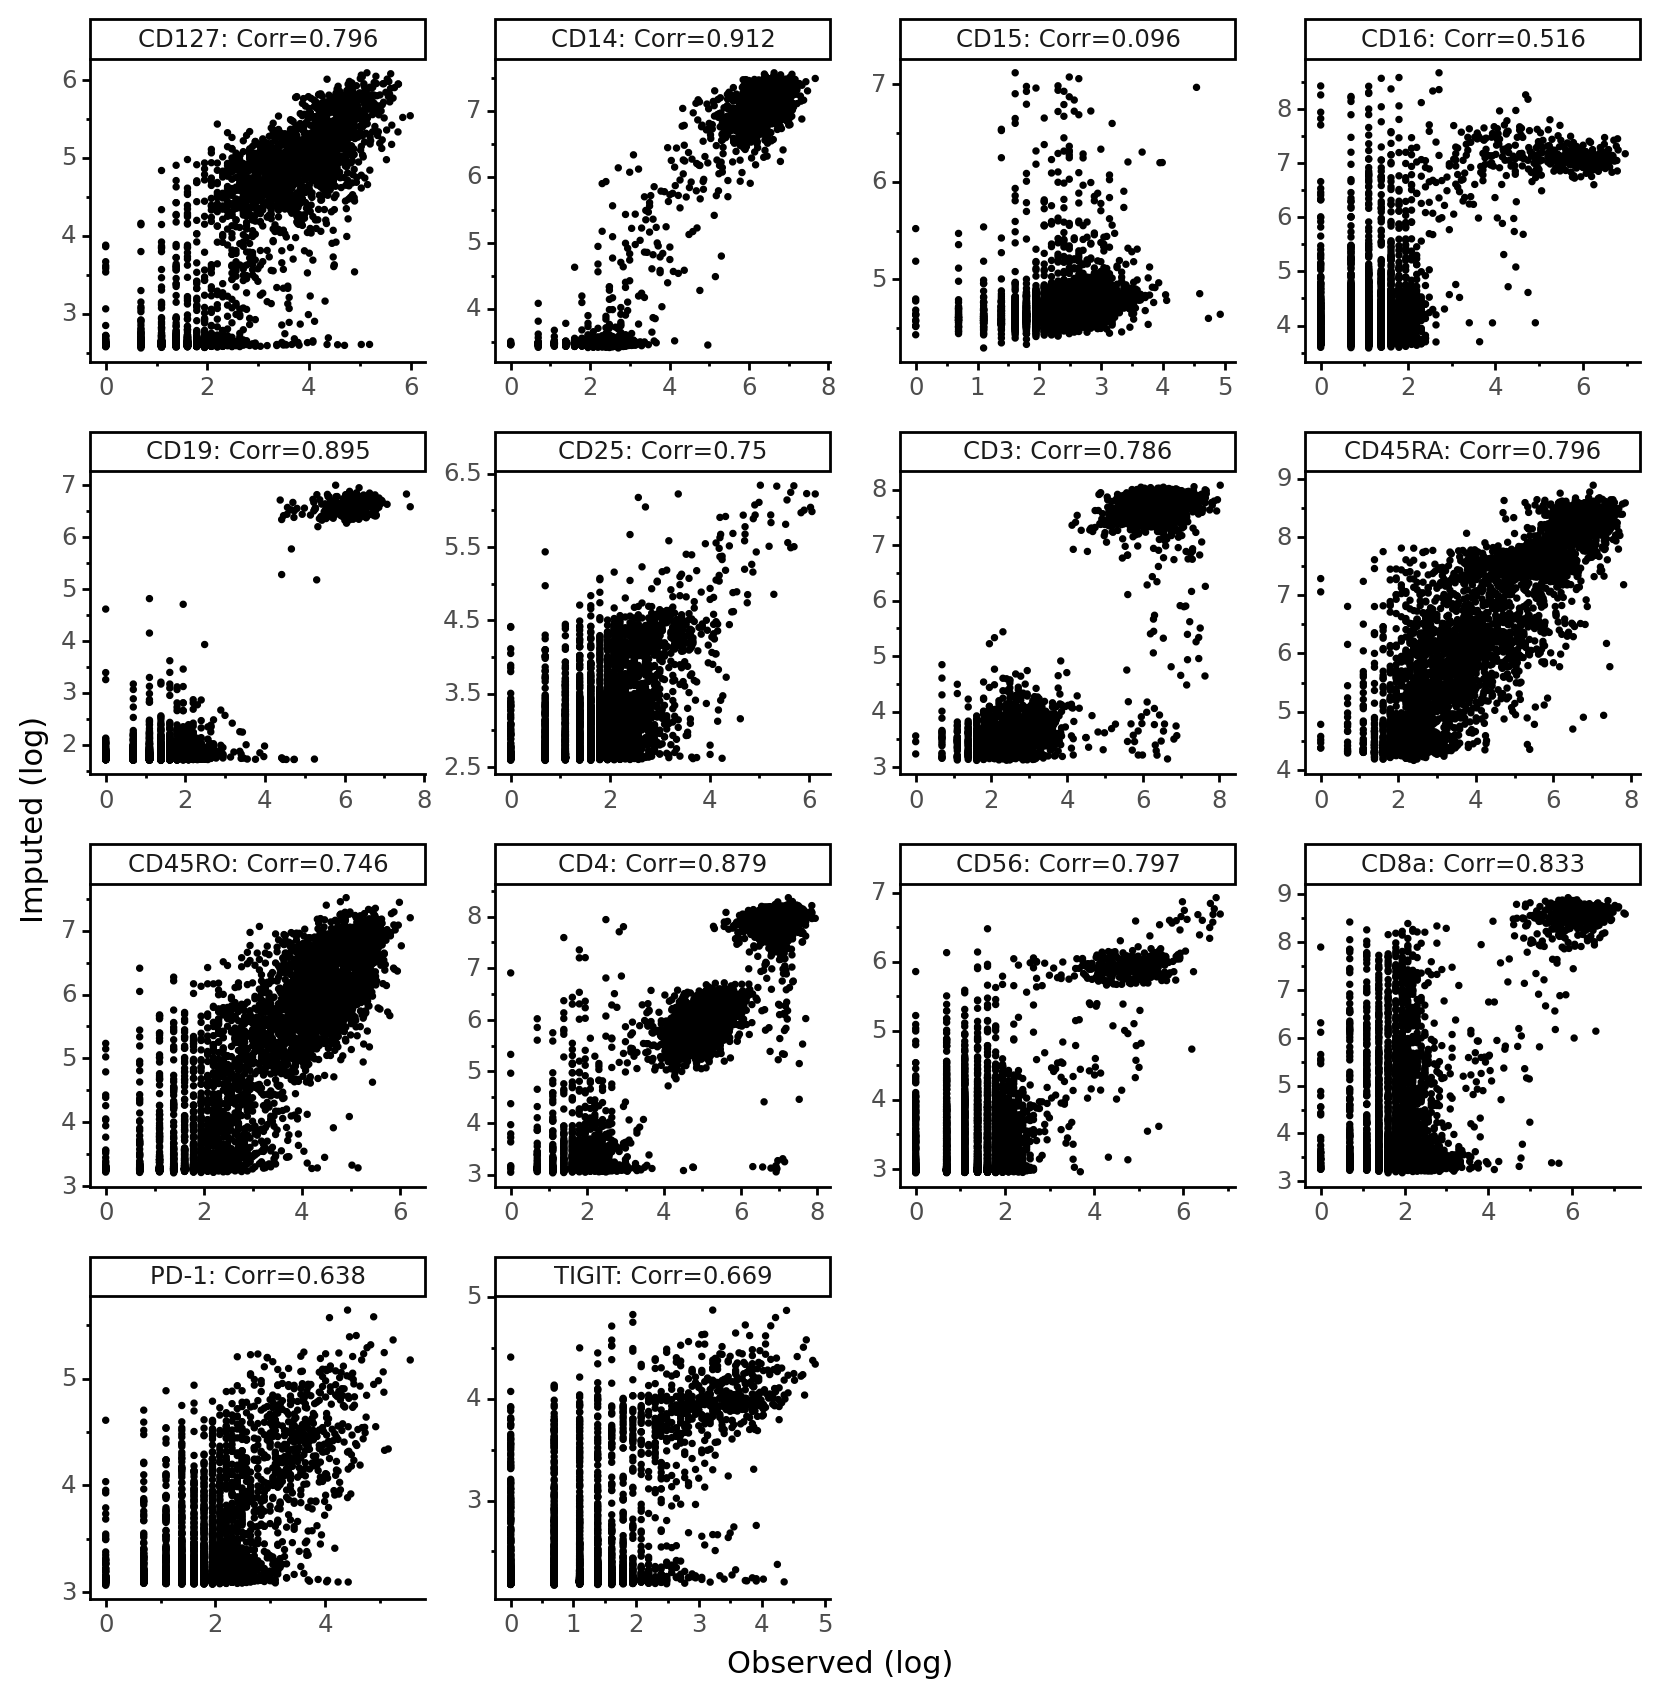

<ggplot: (8737310515573)>

In [25]:
p9.theme_set(p9.theme_classic)
(p9.ggplot(held_vs_denoised, p9.aes("Observed (log)", "Imputed (log)"))
 + p9.geom_point(size=0.5)
 + p9.facet_wrap("~Protein", scales="free")
 + p9.theme(figure_size=(10, 10), panel_spacing=.35,)
)
